# <p style="text-align: center;">MIS 285N: Big Data and Distributed Programming</p>
# <p style="text-align: center;">Project - 1 : Apache Spark</p>
## <p style="text-align: center;">Instructor: Dr. Ramesh Yerraballi</p>
## <p style="text-align: center;">Due: Tuesday, September 14th submitted via Canvas by 11:59 pm</p>

Your work should be written in a **Jupyter notebook**.   

Also, please make sure your code runs in your notebook before submitting.

**Note:**

This project is based on Map-Reduce Framework. In these you will get to work with Spark and will get to know how 
does spark work, what functionalities does spark provide, what does map-reduce framework do and why is it useful. 

In this project you will be implementing a basic song recommender system. You will be given a dataset where there are multiple csv files. These csv files have data corresponding to song play count and song information.

The data you would be using will be provided in a zip file along with this notebook. The __msd.zip__ archive contains:
1. **'kaggle_visible_evaluation_triplets.txt'**. We will be using the visible part of the testing data to understand the working on Apache Spark.  The user's listening history is provided as: (user, song, play count).  
2. In **'kaggle_songs.txt'** file, each song is marked using an index for easier representation of songs.  
3. And **'kaggle_users.txt'** file is the canonical list of user identifiers.
4. Take **'MSDChallengeGettingstarted.pdf'** as your reference.



### **What to turn in?**  

A zip folder which will have:
1. Jupyter Notebook
2. A brief report in PDF format on what features you used for recommendation. And a brief explanation of flow of your code. For example,  what RDD does what or, why it was created.
3. datasets folder with the csv files you are using in your notebook.
4. Notebook should use relative path to the csv files in datasets folder.
5. Name of the zip folder - `<your_name>_<your_partner_name>.zip`

This project consists of 4 questions:  

1. Create an RDD with _kaggle_visible_evaluation_triplets.txt_ and replace the song name with the song index from _kaggle_songs.txt_. Identify the number of songs that do not have any rating. 
2. Generate song ratings based on the song play count as a normalized score between 0 and 1. 
3. Identify the popular song based on this rating and recommend songs to user, given user id based on the algorithm used in Movie recommender system from class. 
4. Using Cosine similarity function, identify pair-wise similarity between each pair of users and generate the top 5 most similar users without an overlap in users. 

The above list is the higer level idea about the questions. 

In [2]:
### Starter code ####
import findspark
findspark.init('/opt/homebrew/Cellar/apache-spark/3.1.2/libexec')
from pyspark import SparkConf, SparkContext
import numpy as np
import pandas as pd
import math
conf = SparkConf().setMaster("local[*]").setAppName("Songs")
sc = SparkContext(conf = conf)
#### These lines are to tell jupyter where to find Apache Spark ####

In [2]:
#sc.stop()

In [3]:
## Read triplet file into RDD
triplet_rdd = sc.textFile(r"kaggle_visible_evaluation_triplets.txt").map(lambda line: line.split("\t")) 

## Step 1: 
Replace song name with song index and identify the number of songs without user history

In [4]:
# Creating a Song RDD by getting the data from kaggle_songs.txt. The seperator is a " " blank space because that is how data is separated in the text file.
song_rdd = sc.textFile(r"kaggle_songs.txt").map(lambda line: line.split(" ")) 

In [5]:
# Creating a dictionary from the Song RDD
song_dict = song_rdd.collectAsMap()

# Applying a function to replace all song names in Triplet RDD with the song index using dictionary created above
triplet_rdd = triplet_rdd.map(lambda x: (x[0],song_dict[x[1]],int(x[2])))

In [6]:
triplet_rdd.take(5)

[('fd50c4007b68a3737fe052d5a4f78ce8aa117f3d', '25150', 1),
 ('fd50c4007b68a3737fe052d5a4f78ce8aa117f3d', '68212', 1),
 ('fd50c4007b68a3737fe052d5a4f78ce8aa117f3d', '87433', 1),
 ('fd50c4007b68a3737fe052d5a4f78ce8aa117f3d', '123630', 1),
 ('fd50c4007b68a3737fe052d5a4f78ce8aa117f3d', '58821', 1)]

In [7]:
# Creating a list of all song indexes in the Triplet RDD
ratings_list = triplet_rdd.map(lambda x: x[1]).distinct().collect()

# Creating a list of all song indexes in the Song RDD
songs_list = song_rdd.map(lambda x: x[1]).collect()

In [8]:
# Created a "songs without rating" list by getting all song indexes that are present in Song RDD but not in Triplet RDD
songs_without_rating = list(set(songs_list) - set(ratings_list))
print ("Number of Songs without a Review: " + str(len(songs_without_rating)))

Number of Songs without a Review: 223007


## Step 2:
Generate song ratings based on the play_count. For example, if (song_1, 5; song_2, 10; song_3, 5) i.e., song_1 is played 5 times, song_2 is played 10 times and song_3 is played 5 times, the normalized rating score should be 0.25, 0.5 and 0.25 respectively. 
Similarly, generate the rating for all the songs. You may notice that based on all songs, the rating is almost always very low. So, think of the best way to convert song count to ratings. (Hint: Try generating ratings based on each user's song play history)

In [9]:
from pyspark.mllib.linalg import Vectors

#get the number of songs played per user  
user_and_songcount_rdd = triplet_rdd.map(lambda x: (x[0],x[2])).reduceByKey(lambda x, y: x + y)
print('Total listens per user:')
user_and_songcount_rdd.take(3)

Total listens per user:


[('d8cd9cadd9d272ef20502a8d5f852b70d35cac5d', 10),
 ('f14527e60c4f8ab8beb9ed696a88153098830434', 9),
 ('dd5ec2cbecee11c833ea060d469bc024f803fc5b', 53)]

In [10]:
# average song/total songs per user  
user_data_join = user_and_songcount_rdd.join(triplet_rdd)
find_avg_per_user = user_data_join.map(lambda x: (x[0],x[1][1],1/x[1][0]))

user_data_join.take(3)

[('c560f3af134d1f3020495487520e01af25cec255', (79, '249392')),
 ('c560f3af134d1f3020495487520e01af25cec255', (79, '246815')),
 ('c560f3af134d1f3020495487520e01af25cec255', (79, '104276'))]

In [11]:
find_avg_per_user.take(3)

[('c560f3af134d1f3020495487520e01af25cec255', '249392', 0.012658227848101266),
 ('c560f3af134d1f3020495487520e01af25cec255', '246815', 0.012658227848101266),
 ('c560f3af134d1f3020495487520e01af25cec255', '104276', 0.012658227848101266)]

In [12]:
# sum of averages /song
sum_avg_per_song = find_avg_per_user.map(lambda x: (x[1],x[2])).reduceByKey(lambda x, y: x + y)
sum_avg_per_song.take(3)

[('346138', 17.852888815653127),
 ('219271', 0.037037037037037035),
 ('187204', 0.36482179306836054)]

In [13]:
# number of users that has listened to a song
song_per_user_count_rdd = triplet_rdd.map(lambda x: (x[1],x[0].split())).reduceByKey(lambda x, y: x + y) 
song_per_user = song_per_user_count_rdd.map(lambda x: (x[0],len(x[1])))
song_per_user.take(3)

[('22943', 21), ('134281', 26), ('131492', 17)]

In [14]:
score_rdd = sum_avg_per_song.join(song_per_user).map(lambda x: (x[0],x[1][0]/x[1][1]))
score_rdd.take(5)

[('136739', 0.03311965811965812),
 ('28819', 0.047619047619047616),
 ('237356', 0.0220066647470515),
 ('207351', 0.02254305977710233),
 ('43775', 0.030443320174557986)]

In [15]:
minimum = score_rdd.map(lambda x: (x[1])).min()
maximum = score_rdd.map(lambda x: (x[1])).max()

normalized_rdd = score_rdd.map(lambda x: (x[0],round((x[1]-minimum)/(maximum-minimum),2)))
normalized_rdd.take(5)

[('136739', 0.16),
 ('28819', 0.24),
 ('237356', 0.11),
 ('207351', 0.11),
 ('43775', 0.15)]

## Step 3: 
For a given user_id (choose one by yourselves), rating, recommend 5 other songs from the list. One way to do this is based on another user who liked the same song liked by this user with rating more than the given rating and recommend the 5 songs based on the matched user's rating. 

In [16]:
user_id = '4de7b737b85dbc706ff4a9182f7a15e2a798ce89'
rating_threshold = 0.1

# Most played song by current user
user_songs = triplet_rdd.filter(lambda x: x[0] == user_id)
most_played_song = user_songs.takeOrdered(1, key=lambda x: -x[2])
print('Highest played song of current user:\n')
print(most_played_song)
most_played_song = int(most_played_song[0][1])

Highest played song of current user:

[('4de7b737b85dbc706ff4a9182f7a15e2a798ce89', '37071', 3)]


In [17]:
# Creating an RDD with song index, people who have listened to that song, and the number of times they have listened to a specific song
song_per_user_count_and_listens = triplet_rdd.map(lambda x: (x[1],[x[0],x[2]])).reduceByKey(lambda x, y: x + y)

# creating list of people who listen to the same song
song_listeners = song_per_user_count_and_listens.filter(lambda x: x[0] == str(most_played_song))
print('RDD with song index and users who have listened to that song with their listen count')
song_per_user_count_and_listens.take(1)

RDD with song index and users who have listened to that song with their listen count


[('2350',
  ['91b8fac7dc5e03f6cfaf6e2aa7171f14a8354d62',
   1,
   '1d285c163eb0bf5f06132ea245b015a1be959b8f',
   2,
   '144bcc07b189a37b8c4266c92d34fb1fb1fe9496',
   1,
   'bfdeb77200b4008b123a49475aaf6f1dbb62bb79',
   13,
   'a8db4c77efce5334643e853983599636616da657',
   1,
   '11b098c2feace8d63b8e01f3f0214e5044de99ae',
   1,
   'eefd2b9ddf77b1059aec9f9dda1a1fbbb32d3956',
   1,
   '1bf29f880df1fddedda13c94b799095738eaca3e',
   1,
   '157a02ce88f80758c140c4427365c192916584a4',
   1,
   '5645c20ef3623f8f4594a35ed39ac6ff4feb8f0d',
   1,
   '8dce84bbdafcb58e86e3dea18f5cb4ee3381965b',
   1,
   'cc2f3392289240d400c9997402dba38d0dace65e',
   1,
   'a199fefde2d118ccf4a5bbcbe6c182a856ae7e9c',
   1,
   '3f4a7d03051f181437b0bedd7b00e25be7f6b4a8',
   1,
   'edd05c78783726e515d760832480b71a3adf68f2',
   2,
   '3a15d373ca5ad20d257b366dcd2d8dba4a36ce0c',
   1,
   '0dd895dee58627b7100cc51e07ddb87f3f8d5868',
   1,
   '3e8cc3b631f37bd4fd3511587adad072caa68fc5',
   1,
   'c363ae768d934f11062a840bb3536b5

In [18]:
# calculating the max to find the person who has the highest listens of the same song
it = iter(song_listeners.take(1)[0][1])
res_dct = dict(zip(it, it))
max_user = max(res_dct, key=res_dct.get)
print('Person who has listened song ' + str(most_played_song) + ' the most\n')
print(max_user, ': ', res_dct[max_user])

Person who has listened song 37071 the most

9da2ceb8d08ed89e386a30ee09f24b0ccc9159e5 :  23


In [19]:
#creating RDD of all songs this user listens to with the listen count and rating
max_user_listen_history = triplet_rdd.filter(lambda x: x[0] == max_user).map(lambda x: (x[1],x[2])).join(normalized_rdd).map(lambda x: (x[0],x[1][0],x[1][1]))

# applying filter on RDD to view songs above rating threshold
recommended_songs = max_user_listen_history.filter(lambda x: float(x[2]) >= rating_threshold)
recommended_songs = recommended_songs.filter(lambda x: float(x[0]) != most_played_song)
recommended_songs = np.array(recommended_songs.takeOrdered(5, key=lambda x: -x[1]))
recommended_songs

array([['307202', '40', '0.19'],
       ['277613', '6', '0.16'],
       ['261781', '2', '0.18'],
       ['206088', '2', '0.18'],
       ['170852', '1', '0.18']], dtype='<U6')

In [20]:
print('Recommended songs based on given criteria:\n')
recommended_songs[:,0]

Recommended songs based on given criteria:



array(['307202', '277613', '261781', '206088', '170852'], dtype='<U6')

## Step 4: 
1. Compute cosine similarity between all pairs of users. 
2. Sort the similarity score and print the top-5 similar users. 
3. If the top-5 user set has an user appearing more than once, ignore that pair and take the next best pair from the sorted list. 
4. For a given user_id, identify the top-5 similar users and hence song recommendations from other user's list. 

In [22]:
# grouping users by their interests. The RDD contains the user ID with a list of all songs they listen to
user_interests = triplet_rdd.map(lambda x: (x[0],[int(x[1])])).reduceByKey(lambda x, y: x + y)
# Taking a sample from the data since the complete dataset was overloading my local machine
user_interests = user_interests.sample(False, 0.10)
print(user_interests.take(10))

[('6462c3efc997aca228a6db9b7f36c69660beb2f8', [214142, 279339, 25323, 341773, 370852, 293373, 243769]), ('d8f4b0a02dd1a579bc61a6c2666314373da1e92b', [281772, 48148, 165488, 75497, 366556, 28476, 16220, 10986, 159300, 51814]), ('9583b70e9bf0186a7fb99c97faa6f0fa3364c479', [101204, 241705, 114624, 283872, 371952, 68590, 133058, 317996, 98159, 193206, 290728, 100191, 23494]), ('3fed46361b15f2303b722bca1c8f458a2435a24e', [331326, 368622, 217471, 177172, 349271, 318169]), ('86627b4bdda36fb6a20e0a7c02adb54cc8cebff1', [169045, 257091, 227594, 112901, 291932, 155456, 196116, 94595, 111517, 72331, 59158, 290621, 83258, 306006, 370081, 142859]), ('6d84f128a8809480bfef65d418df1a4ece676820', [30838, 301077, 123457, 94559, 39842, 38941, 252177, 171004, 307414]), ('2b52851622039acbf8a0e6d46f2580d77d4a6dab', [280553, 313442, 123630, 43911, 364376, 245243]), ('73aa5b778cc88f720d5a6fdecbc242023d5ad0a9', [263887, 234086, 177261, 165401, 307098, 304697, 182435, 97555, 162907, 285175, 114624, 83123, 98159,

In [26]:
# interest matrix is of all songs each user listens to stored as a list
interest_matrix = user_interests.map(lambda x: x[1]).collect()
print(interest_matrix[0])
# users list is a list of all distinct users, and matches the index of the interest matrix above
users_list = user_interests.map(lambda x: x[0]).collect()
print(users_list[0])

[119799, 263177, 18857, 232546, 258181, 25323, 215861, 321802, 207699]
202c63cd3568680561e84d33bc35740d662efccf


For Cosine similarity, we took advantage if the fact that the matrix only had 1's and 0's. Rather than computing the complete interest matrix for each user, we took a different approach to calculate the cosine similarities > 0 without using too much memory, since the operations were very slow on local computers even after taking a sample from the dataset. Below is a picture of our logic for calculating cosine similarities (the result is the same, we are just using an efficient way of calculating the values)

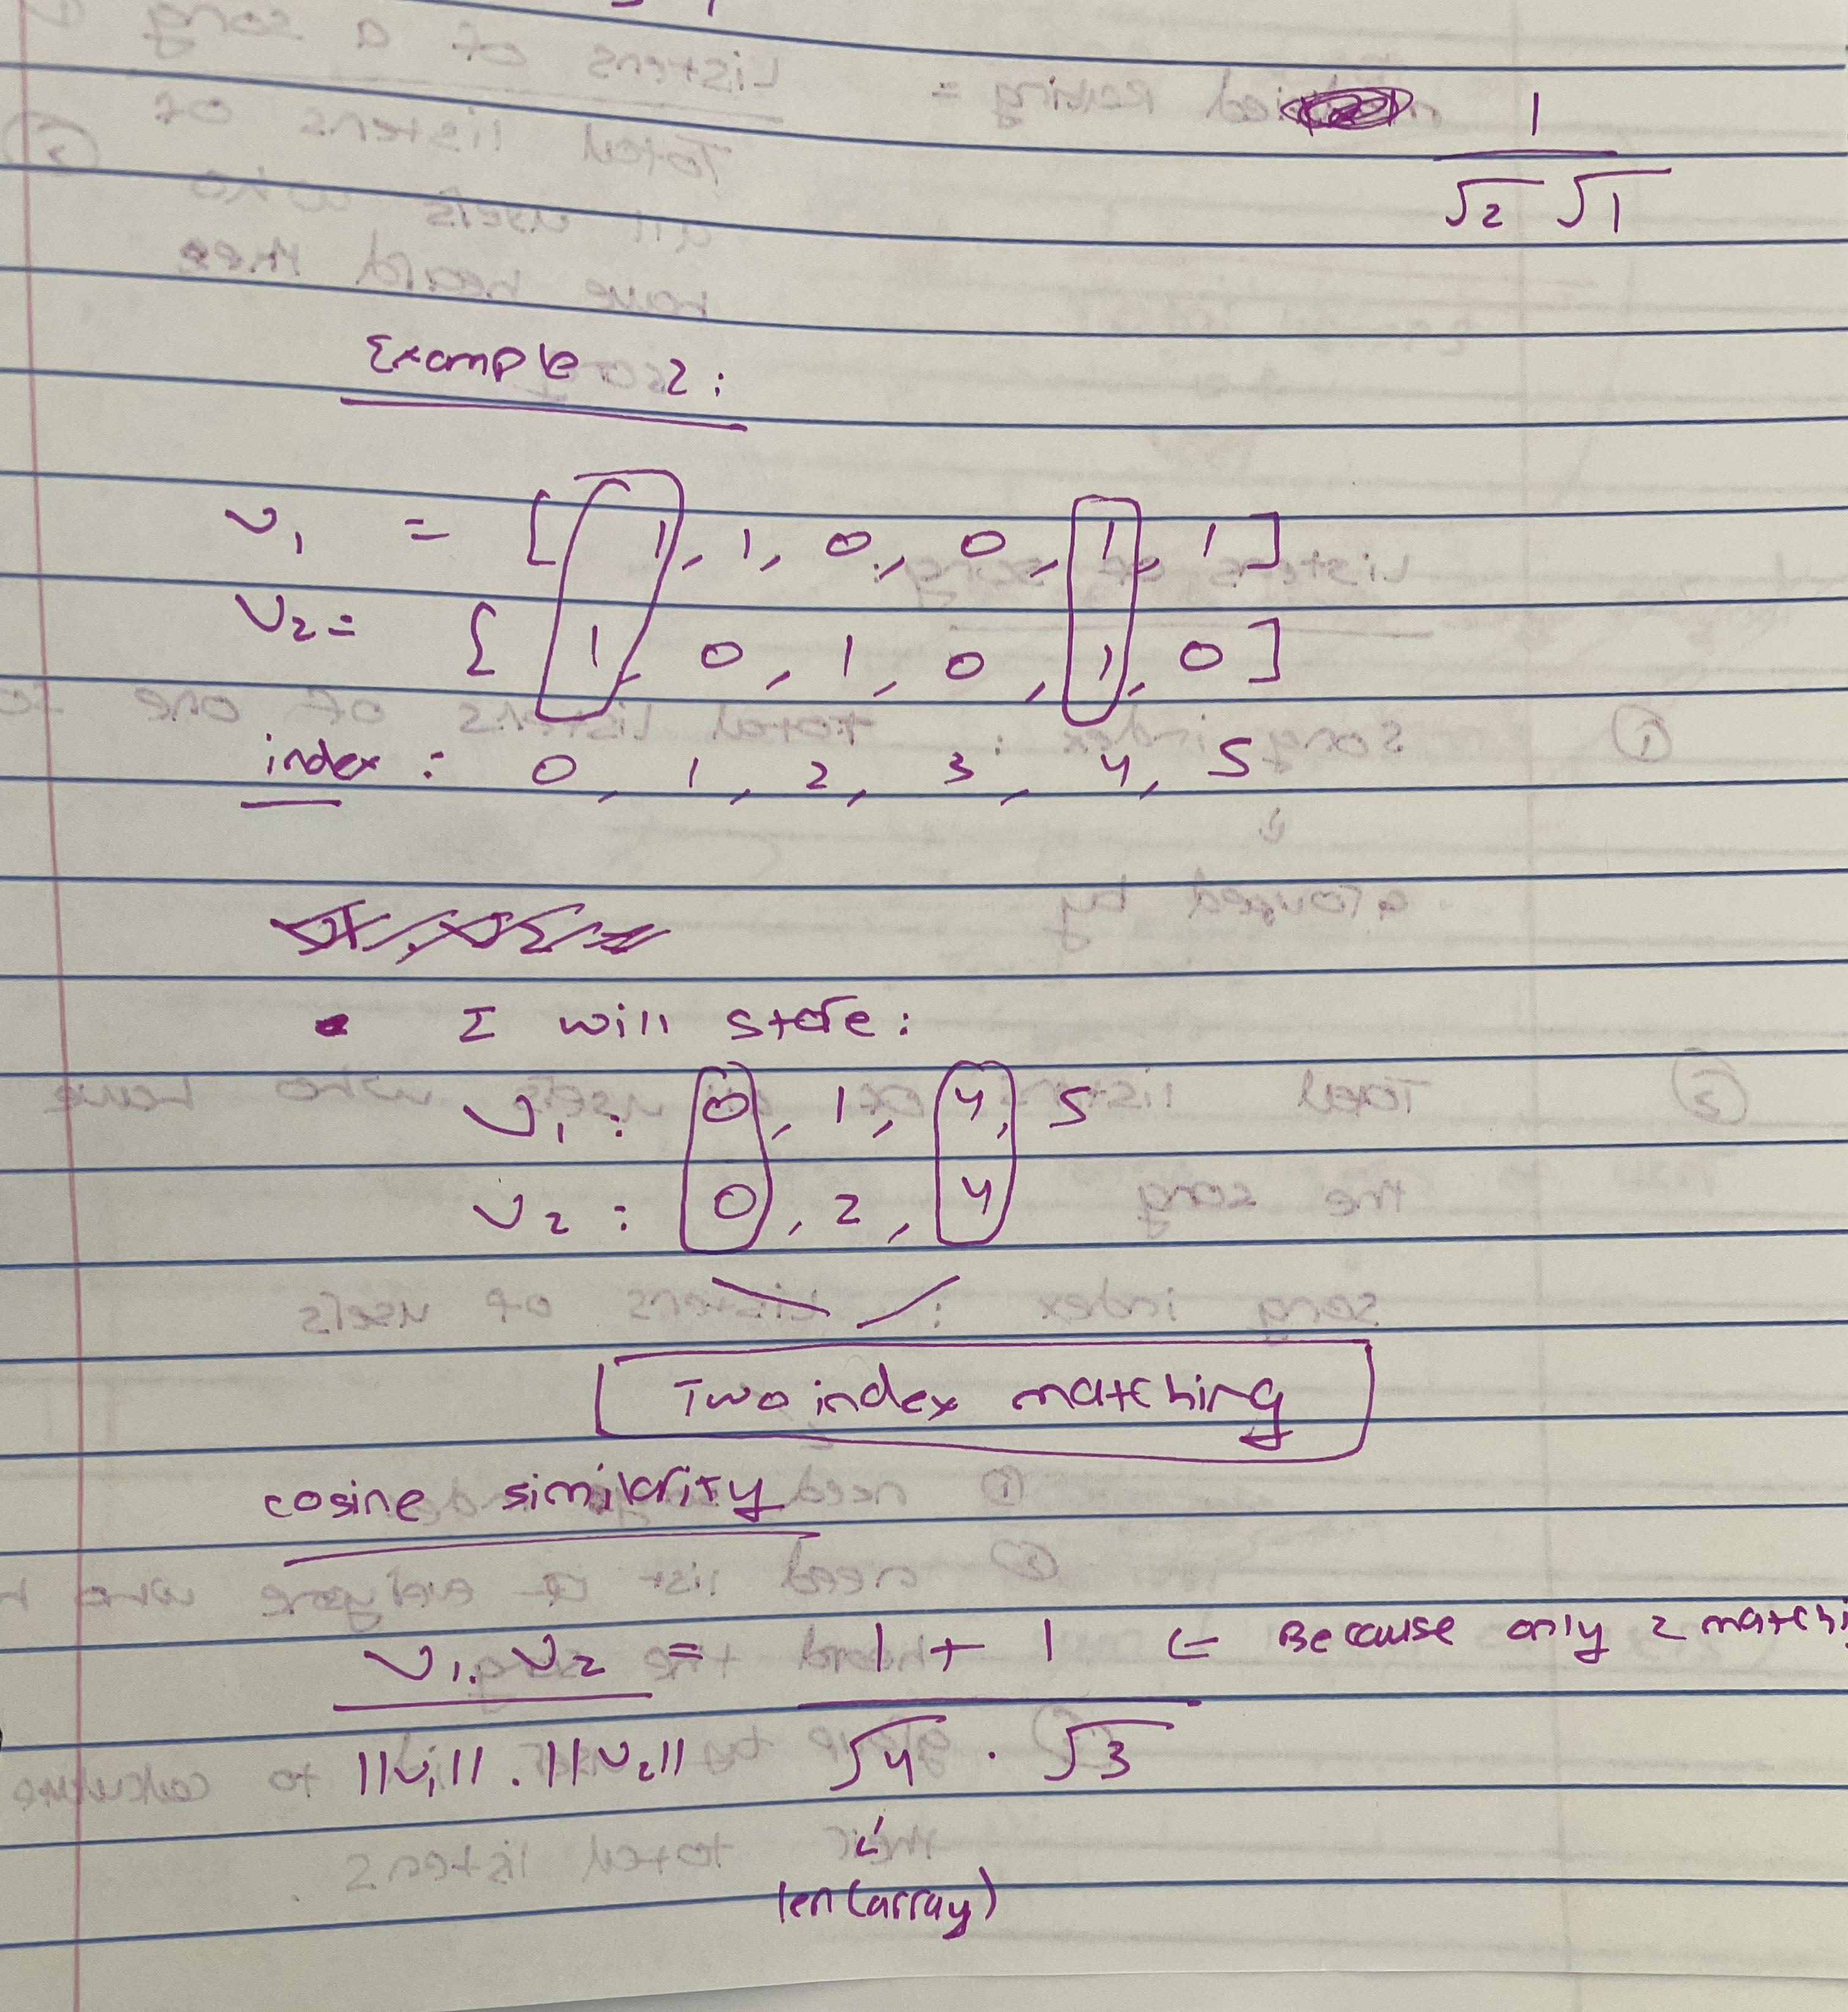

In [30]:
def cosine_similarity(current_user, current_matrix, users_list, interest_matrix):
    cosine_list = []
    user = []
    current_matrix_len = len(current_matrix)
    for i in range(len(interest_matrix)):
        # calculation for the dot product = length of intersection of two vectors
        vector_intersection = len(list(set(current_matrix) & set(interest_matrix[i])))
        if ((vector_intersection != 0) and (users_list[i] != current_user)):
            # l2 norms for both vectors calculated by taking square root of their lengths
            cosine_list.append(vector_intersection / math.sqrt(current_matrix_len * len(interest_matrix[i])))
            user.append(users_list[i])
    return sorted(zip(cosine_list, user), reverse=True)

# similarity matrix is mapping the cosine similarity function on the RDD and returning a list of sorted cosine similarities for each user that are > 0
similarity_matrix = user_interests.map(lambda x: (x[0], list(cosine_similarity(x[0], x[1], users_list, interest_matrix))))

In [ ]:
similarity_matrix.take(1)

In [ ]:
# 2. Sort the similarity score and print the top-5 similar users.
sm_sorted = similarity_matrix.sortBy(lambda x: x[1][0])
top5_similar_users = np.array(sm_sorted.takeOrdered(5, key=lambda x: -x[1][0]))

In [ ]:
#3. If the top-5 user set has an user appearing more than once, ignore that pair and take the next best pair from the sorted list.

In [ ]:
#4. For a given user_id, identify the top-5 similar users and hence song recommendations from other user's list.

all_songs = []
def recommended_songs(user):
     #creating RDD of all songs this user listens to with the listen count and rating
    max_user_listen_history = triplet_rdd.filter(lambda x: x[0] == user).map(lambda x: (x[1],x[2])).join(normalized_rdd).map(lambda x: (x[0],x[1][0],x[1][1]))
    
    # applying filter on RDD to view songs above rating threshold
    recommended_songs = max_user_listen_history.filter(lambda x: float(x[2]) >= rating_threshold)
    recommended_songs = recommended_songs.filter(lambda x: float(x[0]) != most_played_song)
    recommended_songs = np.array(recommended_songs.takeOrdered(5, key=lambda x: -x[1])).tolist()
    return recommended_songs

def get_song_recommendation(user):
    get_other_users = sm_sorted.filter(lambda x: x[0] = user).sortBy(lambda x: x[1][0]).map(lambda x: x[1][1]).collect() 
    for user in get_other_users[:5]:
        all_songs.append(recommended_songs(user))
    return set(all_songs)
        
get_song_recommendation(user)